*A notebook on a shrinkage correction approach where we just run PCA holding 1 single sample at a time for every sample ...*

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections as mc
import pandas as pd

import pcshrink

# Data prep

Read in the human origins west eurasian data

In [2]:
%%time
data = pcshrink.UnpackedAncestryMap("/project/jnovembre/jhmarcus/ancient-sardinia/data/ref_genotypes/7-11-2018/lazaridis_2014/data_fil")

CPU times: user 7.56 s, sys: 2.56 s, total: 10.1 s
Wall time: 8.06 s


extract a subset just for experimentation

In [3]:
clst_str = """HGDP01062   F   Sardinian
HGDP01063   M   Sardinian
HGDP01064   F   Sardinian
HGDP01065   F   Sardinian
HGDP01066   M   Sardinian
HGDP01067   M   Sardinian
HGDP01068   F   Sardinian
HGDP01069   M   Sardinian
HGDP01070   F   Sardinian
HGDP01071   M   Sardinian
HGDP01072   F   Sardinian
HGDP01073   M   Sardinian
HGDP01074   F   Sardinian
HGDP01075   M   Sardinian
HGDP01076   M   Sardinian
HGDP01077   M   Sardinian
HGDP01078   F   Sardinian
HGDP01079   M   Sardinian
HGDP01381   F   Adygei
HGDP01382   F   Adygei
HGDP01383   M   Adygei
HGDP01385   M   Adygei
HGDP01386   F   Adygei
HGDP01387   F   Adygei
HGDP01396   M   Adygei
HGDP01397   M   Adygei
HGDP01398   F   Adygei
HGDP01399   F   Adygei
HGDP01400   F   Adygei
HGDP01401   F   Adygei
HGDP01402   M   Adygei
HGDP01403   M   Adygei
HGDP01404   M   Adygei
HGDP00511   M   French
HGDP00512   M   French
HGDP00513   F   French
HGDP00514   F   French
HGDP00515   M   French
HGDP00516   F   French
HGDP00517   F   French
HGDP00518   M   French
HGDP00519   M   French
HGDP00522   M   French
HGDP00523   F   French
HGDP00524   F   French
HGDP00525   M   French
HGDP00526   F   French
HGDP00527   F   French
HGDP00528   M   French
HGDP00529   F   French
HGDP00531   F   French
HGDP00533   M   French
HGDP00534   F   French
HGDP00535   F   French
HGDP00536   F   French
HGDP00537   F   French
HGDP00538   M   French
HGDP00539   F   French"""


In [4]:
clst_str = """HGDP01062   F   Sardinian
HGDP01063   M   Sardinian
HGDP01064   F   Sardinian
HGDP01065   F   Sardinian
HGDP01066   M   Sardinian
HGDP01067   M   Sardinian
HGDP01068   F   Sardinian
HGDP01069   M   Sardinian
HGDP01070   F   Sardinian
HGDP01071   M   Sardinian
HGDP01072   F   Sardinian
HGDP01073   M   Sardinian
HGDP01074   F   Sardinian
HGDP01075   M   Sardinian
HGDP01076   M   Sardinian
HGDP01077   M   Sardinian
HGDP01078   F   Sardinian
HGDP01079   M   Sardinian
HGDP01381   F   Adygei
HGDP01382   F   Adygei
HGDP01383   M   Adygei
HGDP01385   M   Adygei
HGDP01386   F   Adygei
HGDP01387   F   Adygei
HGDP01396   M   Adygei
HGDP01397   M   Adygei
HGDP01398   F   Adygei
HGDP01399   F   Adygei
HGDP01400   F   Adygei
HGDP01401   F   Adygei
HGDP01402   M   Adygei
HGDP01403   M   Adygei
HGDP01404   M   Adygei
HGDP00511   M   French
HGDP00512   M   French
HGDP00513   F   French
HGDP00514   F   French
HGDP00515   M   French
"""


clsts = list(map(lambda x: x.split('   '), clst_str.split("\n")))
clst_df = pd.DataFrame(clsts)
clst_df.columns = ["iid", "sex", "clst"]

ind_df = pd.DataFrame({"iid": data.inds})
ind_df

mrg_df = ind_df.reset_index().merge(clst_df, how="inner", on="iid")
idx = mrg_df["index"].as_matrix()

/project/jnovembre/jhmarcus/src/miniconda3/envs/pcshrink_env/lib/python3.6/site-packages/ipykernel_launcher.py:50: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [21]:
#Y = data.Y[:, idx]
Y = data.Y
p, n = Y.shape
print(p, n)

594924 777


Find snps that are too rare or too common

In [22]:
# use allele frequency estimator from Price et al. 2006
f = (1. + np.nansum(Y, axis=1)) / (2 + (2. * n))

# keep snps that aren't too rare or common
snp_idx = np.where((f > .02) & (f < .98))[0]
print(f.shape, snp_idx.shape)

(594924,) (426765,)


Mean center and scale and impute missing values to 0

In [23]:
Z = Y[snp_idx, :]

# mean genotype 
mu = np.nanmean(Z, axis=1).reshape(len(snp_idx), 1)

# empirical std deviation
std = np.nanstd(Z, axis=1).reshape(len(snp_idx), 1)

# heterozygosity scaler
het = np.sqrt(2. * f[snp_idx] * (1. - f[snp_idx])).reshape(len(snp_idx), 1)

Z = (Z - mu) / het
Z[np.isnan(Z)] = 0.0

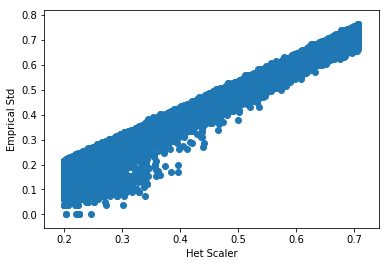

In [26]:
plt.scatter(het, std);
plt.xlabel("Het Scaler");
plt.ylabel("Emprical Std");

# PCA

In [28]:
%%time
k = 5
cor = pcshrink.ShrinkageCorrector(Z, k)

CPU times: user 22.7 s, sys: 979 ms, total: 23.7 s
Wall time: 852 ms


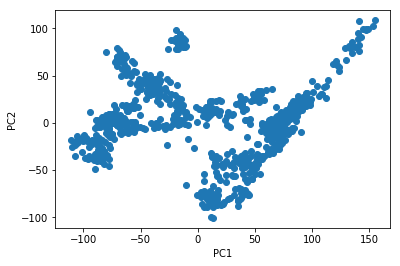

In [29]:
plt.scatter(cor.L[:,0], cor.L[:,1])
plt.xlabel("PC1");
plt.ylabel("PC2");

In [30]:
%%time
cor.jackknife(q=5, o=2)

holding out sample 0
holding out sample 2
holding out sample 4
holding out sample 6
holding out sample 8
holding out sample 10
holding out sample 12
holding out sample 14
holding out sample 16
holding out sample 18
holding out sample 20
holding out sample 22
holding out sample 24
holding out sample 26
holding out sample 28
holding out sample 30
holding out sample 32
holding out sample 34
holding out sample 36
holding out sample 38
holding out sample 40
holding out sample 42
holding out sample 44
holding out sample 46
holding out sample 48
holding out sample 50
holding out sample 52
holding out sample 54
holding out sample 56
holding out sample 58
holding out sample 60
holding out sample 62
holding out sample 64
holding out sample 66
holding out sample 68
holding out sample 70
holding out sample 72
holding out sample 74
holding out sample 76
holding out sample 78
holding out sample 80
holding out sample 82
holding out sample 84
holding out sample 86
holding out sample 88
holding out sam

(777,)

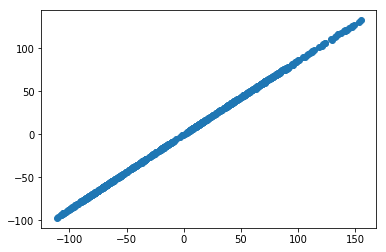

In [31]:
plt.scatter(cor.L[:, 0], cor.L_shrunk[:, 0])
cor.L_shrunk[:, 0].shape
cor.L[:, 0].shape

In [32]:
from sklearn import linear_model
regr = linear_model.LinearRegression(fit_intercept=False, normalize=False)
regr.fit(cor.L_shrunk[:,0].reshape(n, 1), cor.L[:, 0].reshape(n, 1))
regr.coef_

array([[1.15589363]])

Text(0,0.5,'PC2')

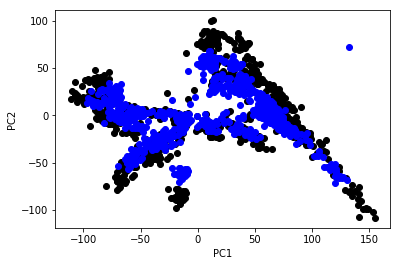

In [40]:
plt.scatter(cor.L[:, 0], -cor.L[:, 1], color="black")
plt.scatter(cor.L_shrunk[:, 0], -cor.L_shrunk[:, 1], color="blue")
plt.xlabel("PC1")
plt.ylabel("PC2")

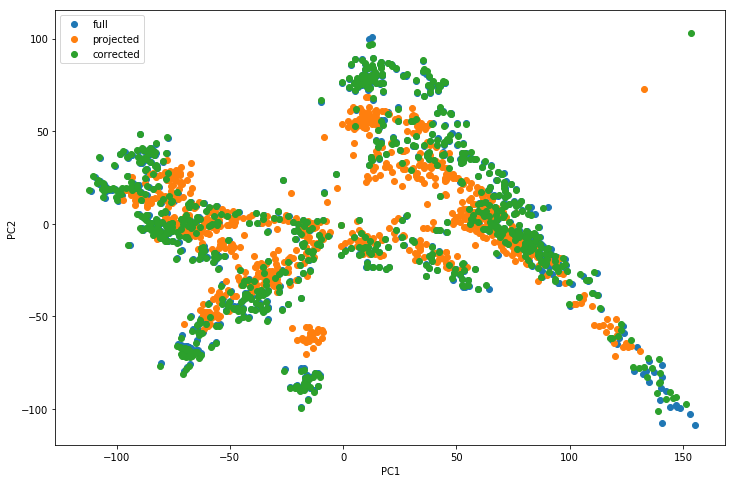

In [37]:
plt.figure(figsize=(12, 8))
plt.scatter(cor.L[:, 0], -cor.L[:, 1], label="full")
plt.scatter(cor.L_shrunk[:, 0], -cor.L_shrunk[:, 1], label="projected")
plt.scatter(cor.tau[0] * cor.L_shrunk[:, 0], -cor.tau[1] * cor.L_shrunk[:, 1], label="corrected")
plt.legend()
plt.xlabel("PC1");
plt.ylabel("PC2");

---

In [ ]:
plt.figure(figsize=(10, 8))
plt.quiver(L[:,0], 
           -L[:, 1], 
           L_[:, 0] - L[:,0],
           -(L_[:, 1] - L[:, 1]), headwidth=2)

plt.xlabel("PC1");
plt.ylabel("PC2");
plt.ylim()
plt.autoscale()


Plot PC1 vs PC2

In [ ]:
%%time

K = 10
q = data.n
L_proj = np.empty((q, K))

for i in range(q):
    
    print(i)
    
    idx = np.ones(data.n, dtype="bool")
    idx[i] = False
    
    z = Z[:, i]
    Z_train = Z[:, idx]
    
    L_proj[i, :] = holdout_pca(z, Z_train, K)
    
#np.save("data/L_proj", L_proj)

In [ ]:
#L_proj = L_proj / np.linalg.norm(L_proj, axis=0, ord=2)

In [ ]:
plt.scatter(L[:, 0], -L[:,1])

In [ ]:
plt.scatter(L_proj[:, 0], -L_proj[:, 1])

In [ ]:
plt.figure(figsize=(12, 8))
#plt.quiver(L_proj[0,0], -L_proj[0,1], L[0,0], -L[0,1],)
plt.quiver(L[:,0], -L[:,1], L_proj[:,0]-L[:,0], -(L_proj[:,1]-L[:,1]))

plt.xlabel("PC1");
plt.ylabel("PC2");
plt.tight_layout()

In [ ]:
#plt.quiver(X=L[:,0], Y=-L[:,1], U=L_proj[:,0], V=-L_proj[:,1])
#plt.xlabel("PC1");
#plt.ylabel("PC2");

lines = []
for i in range(L.shape[0]):
    lines.append([(L[i, 0], -L[i, 1]), (L_proj[i, 0], -L_proj[i, 1])])
    
lc = mc.LineCollection(lines, linewidths=2, colors="black")
fig, ax = plt.subplots(figsize=(12, 8))
ax.add_collection(lc)
ax.autoscale()

plt.xlabel("PC1")
plt.ylabel("PC2")

In [ ]:
np.random.choice(Z.shape[0], 10, replace=False)

In [ ]:
np.arange(10)